# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Erika Do, xdoeri00_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [2]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist()[1:]:
        # TODO test názvu souboru
        try:
            with zf.open(filename, "r") as f:
                content = f.read().decode('utf-8') # reads the content as bytes and converts it into a string
                # vytvořte slovník
                json_data = json.loads(content) # parses a JSON string and converts it into a dictionary
                data.append(json_data)
        except Exception as e:
            print(f"Error: Could not read the {filename}: {e}")

df = pd.DataFrame(data)

try:
    df['run'] = df['run'].astype(int)
    df['runtime'] = df['runtime'].astype(float)
except KeyError as e:
    print(f"Error: Could not find the column for conversion: {e}")
except ValueError as e:
    print(f"Error: Could not convert the value: {e}")

df

,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

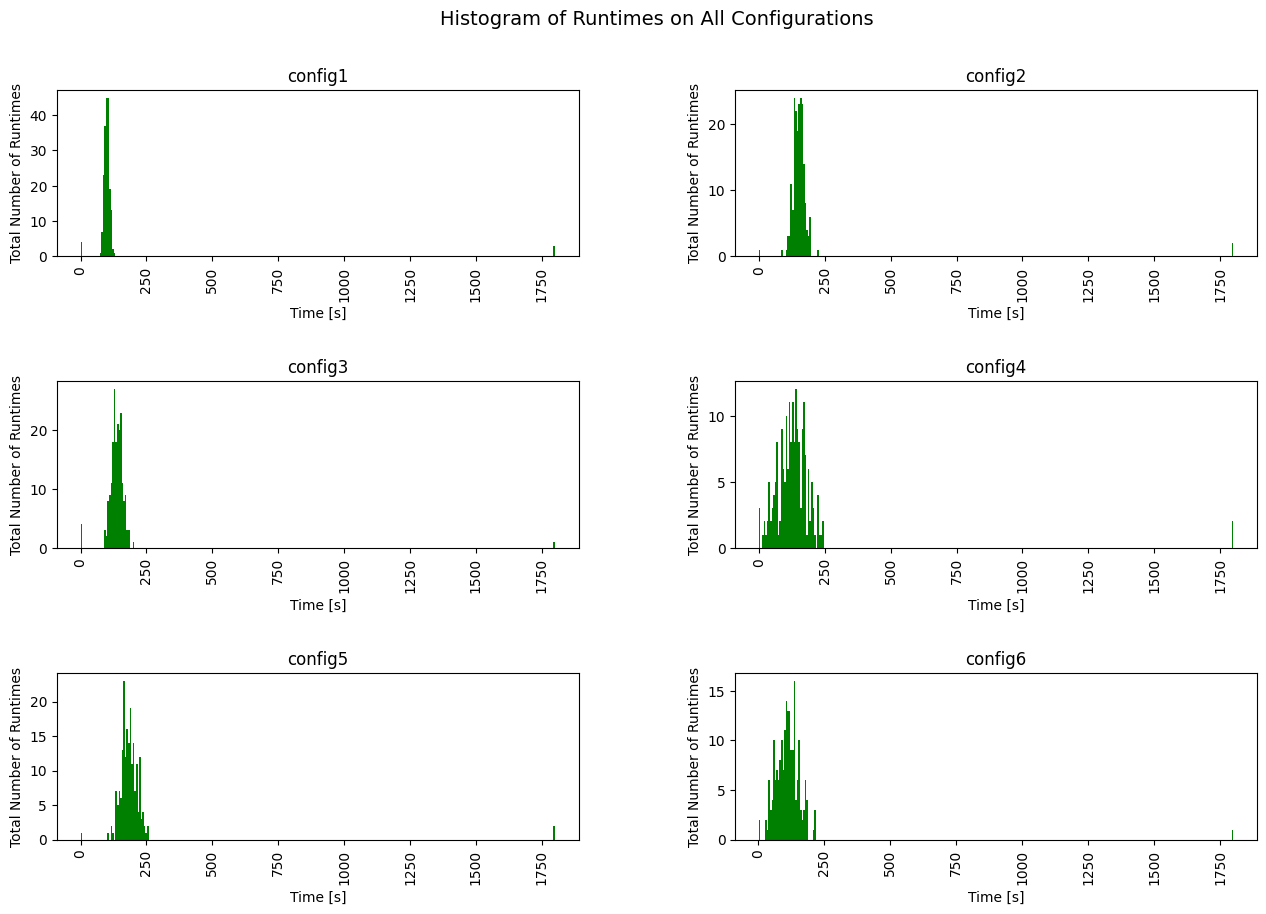

In [3]:
def plot_hist(df):
    axes = df.hist(figsize=(15, 10), by="configuration", column=["runtime"], bins=300, color="green") # by= used to form histograms for separate groups, column= limits data to a subset of columns.
    plt.suptitle("Histogram of Runtimes on All Configurations", fontsize=14)

    for ax in axes.flatten():  # converts an array of axes into a flattened array
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Total Number of Runtimes")

    plt.subplots_adjust(hspace=0.75) # adds vertical gap between each histrogram

plot_hist(df)

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

Jednotlivé konfigurace jsou zobrazené pomocí histogramu, kde x-ová osa reprezentuje čas běhů a y-ová osa udává celkový počet běhů pro daný čas. Na každém grafu si můžeme povšimnout hodnot, které se výrazně odlišují od těch ostatních. Navíc se dané chybné hodnoty objevují v těch samých časech, a to **0** a **1800** sekund.

Vychýlené hodnoty mohou být zapříčiněné problémy, které mohly nastat při běhu algoritmu. Hodnoty s časem **0** sekund mohou souviset s tím, že daný výpočet ani neproběhl – tuto myšlenku podporuje fakt, že u těchto hodnot je status nastavený na `SEGFAULT`. Pro hodnoty s časem **1800** sekund mohl nastat problém opačný, kde algoritmus běžel příliš dlouho a vypršel mu vyhrazený čas. Tentokrát je hodnota statusu `TIME LIMIT`.

Histogram znázorňuje četnost sledované veličiny ("runtime") pomocí sloupcového grafu, díky čemuž je v našem případě jednoduché vidět, kde se dané hodnoty nejvíce shlukují a kde naopak nejsou zastoupeny vůbec.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

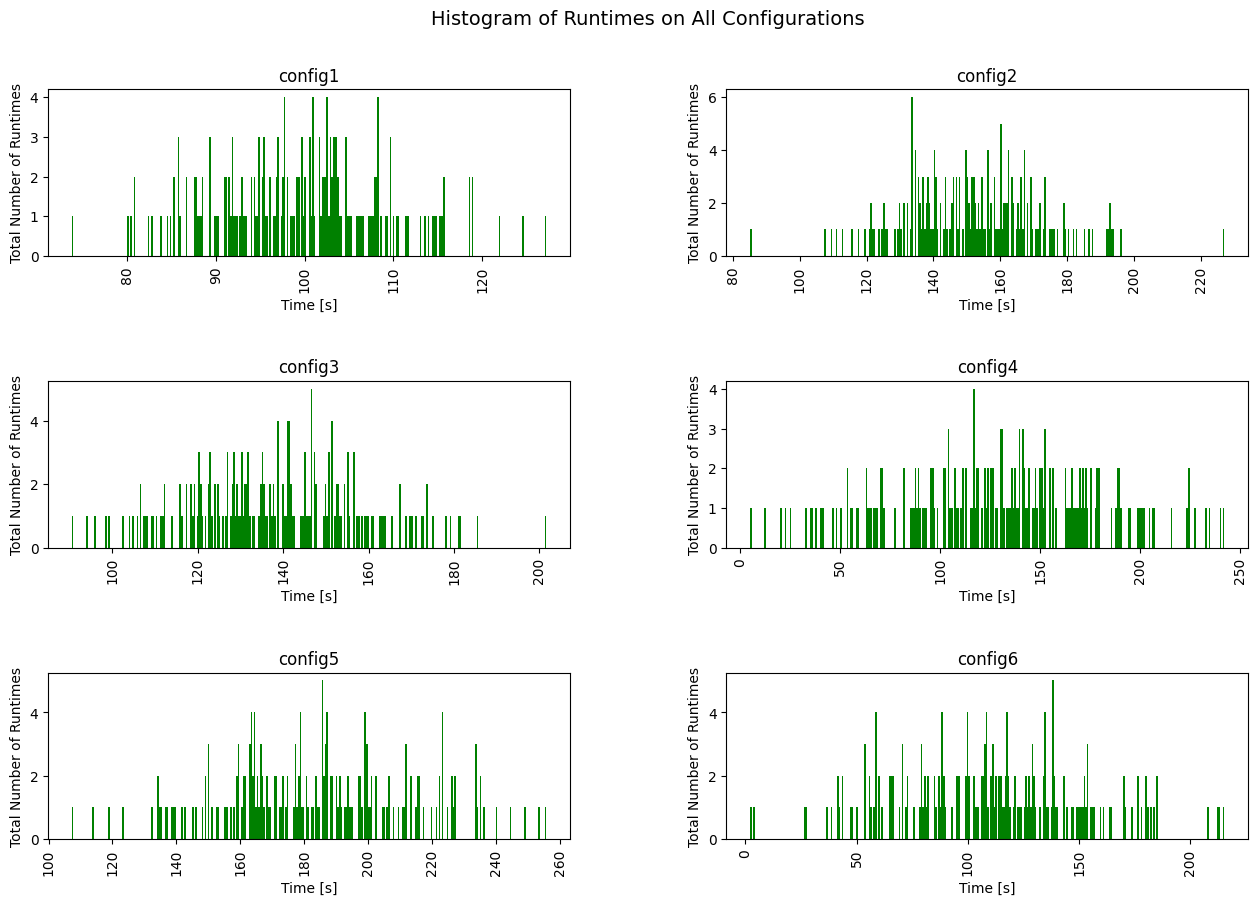

In [4]:
df = df[~df["runtime"].isin([0.0, 1800.0])] # check whether every value in the DataFrame is present in the list (which runtimes have 0 or 1800 seconds)

plot_hist(df)

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
descriptive_stats = df.groupby("configuration") # determines the groups by dict VALUES
descriptive_stats["runtime"].describe() # https://gist.github.com/pb111/512c840affb32593d28573fbb764045b

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,193.0,99.590413,9.386788,73.802549,92.979469,99.865028,104.824724,127.201692
config2,197.0,151.732975,19.833198,85.174653,137.995662,151.516091,163.802880,227.054630
config3,195.0,138.616959,19.867428,90.567110,124.803901,138.678404,151.536291,201.577616
config4,196.0,127.606156,50.282164,4.970286,94.793688,129.975246,164.327163,241.987620
config5,197.0,183.659767,28.729836,107.283620,164.070091,183.843132,201.250693,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Z tabulky je možné vyčíst (zleva doprava v tomto pořadí) četnost naměřených běhů, průměrná doba běhu, směrodatná odchylka, minimální hodnota, percentily 0.25, 0.50, 0.75 a maximální hodnotu běhu pro každou konfiguraci. Percentil 25&nbsp;% (50&nbsp;%/75&nbsp;%) znamená, že 25&nbsp;% (50&nbsp;%/75&nbsp;%) běhů algoritmu je rychlejších než uvedený čas.

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

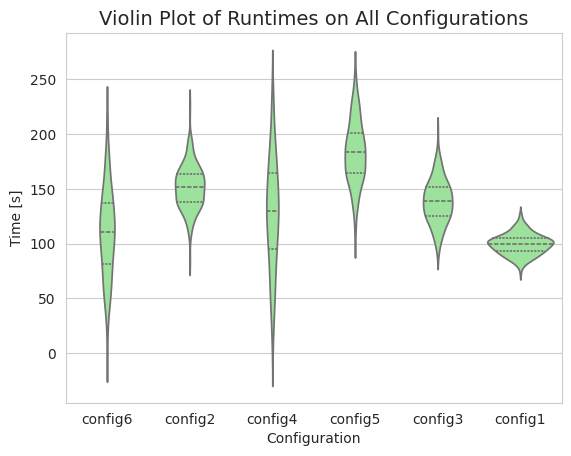

In [6]:
with sns.axes_style("whitegrid"):
    sns.violinplot(x="configuration", y="runtime", data=df, color="lightgreen", inner="quart") # inspiration from: https://www.geeksforgeeks.org/process-pandas-dataframe-into-a-violin-plot/
plt.title("Violin Plot of Runtimes on All Configurations", fontsize=14)
plt.xlabel("Configuration")
plt.ylabel("Time [s]")

plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Při pohledu na houslový graf můžeme za nejefektivnější konfigurace považovat `config1` a `config6`. Knihovna seaborn nám rovněž dovoluje zobrazit kvartily (Q1, Q2, Q3) nad zvolenými daty, v našem grafu je můžeme pozorovat jako tečkované/přerušované horizontální čáry. Můžeme si povšimnout, že `config1` má nižší průměrnou hodnotu a výrazně menší odchylku než `config6`. Z `config6` je však zřejmé, že některé jeho běhy jsou dokončeny v mnohem lepší čase než v případě `config1`. Proto bude nutné podrobit pozorování dalším testům, abychom mohli s jistotou určit, která z konfigurací je efektivnější.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Budou nás zajímat pouze data `config1` a `config6`, které mají normální rozdělení – zjednodušeně řečeno to v našem případě můžeme vypozorovat tak, že křivka grafu připomíná tvar zvonečku (viz **Analýza a čištění dat** – 2. histogram), jež je vycentrovaný v oblasti mediánu. Jelikož jejich variance nabývají odlišných hodnot, ideálním testem je Welchův t-test. Používá se pro soubory, jejichž pozorování **nejsou spárována** a **nemůžeme u nich předpokládat shodný rozptyl**. Testujeme hypotézu $H_0$, kterou se snažíme potvrdit, či vyvrátit. Rovněž si zvolíme opačnou hypotézu $H_1$ (koeficient spolehlivosti $\alpha$ je nejčastěji roven 0.05, necháme tomu tak i v následujícím výpočtu).

<!-- adapted from: https://statistikajednoduse.cz/article/welchuv-test-dvouvyberovy -->
$X_1$ obsahuje pozorování `config1` a soubor $X_2$ pozorování `config6` . Příslušné střední hodnoty pak označíme $μ_{X_1}$ a $μ_{X_2}$. Nyní můžeme formulovat nulovou a alternativní hypotézu:

**$H_0$**: Střední hodnota obou konfigurací je stejná. ($H_0 : μ_{X_1} = μ_{X_2}$)

**$H_1$**: Střední hodnota obou konfigurací je odlišná. ($H_0 : μ_{X_1} \neq μ_{X_2}$)

In [7]:
# TODO: Implementace s využitím knihovní funkcí
result = stats.ttest_ind(df[df.configuration == "config1"].runtime, df[df.configuration == "config6"].runtime, equal_var=False) # performs Welch's T-test

print(result)

# Test to check the normality of df
# ax = sns.boxplot(x = df[df.configuration == "config1"].runtime)
# stat, p = stats.shapiro(df[df.configuration == "config1"].runtime)
# print((stat, p)) # if p > 0.05 => we assume the distribution of our data is normal/gaussian

TtestResult(statistic=-3.64068343471875, pvalue=0.0003391848275884963, df=219.4487569758281)


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

- Konfidenční interval je definován jako $100 \cdot (1 - α) \%$, v tomto případě tedy rovno 95 %.
- Pro df (degrees of freedom) $= 219$ a $α = 0.05$ je kritická hodnota $1.972$ (pro porovnání s hodnotou statistiky $T$ – složka `statistic`) dána distribuční tabulkou pro Studentův t-test. <!-- https://www.stat.purdue.edu/~lfindsen/stat503/t-Dist.pdf -->
- Pokud je $|T| > 1.972$, tak $H_0$ zamítáme, což naznačuje, že mezi průměry obou skupin existuje významný rozdíl.
- Pokud je $|T| \le 1.972$, tak $H_0$ nezamítáme, což naopak indikuje, že není dostatek důkazů k závěru o významném rozdílu mezi průměry obou skupin.
- Pokud $p\geα$, pak to neznamená, že zamítáme $H_1$, ale pouze nezamítáme $H_0$.

S jistotou na 95 % zamítáme hypotézu $H_0$ a potvrzujeme, že střední hodnota obou konfigurací je odlišná. Navíc je $μ_{X_1} < μ_{X_2}$, z čehož vyplývá, že průměrný čas pro dokončení `config1` je menší než průměrný čas pro `config6`. První konfigurace je tedy efektivnější než konfigurace s číslem 6.

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [8]:
# TODO vlastni implementace zvoleneho testu: https://medium.com/@saglamfarukcan/understanding-welchs-t-test-a-robust-approach-for-unequal-variances-34dad43cbf41
conf1_mean = (df[df.configuration == "config1"].runtime).mean()
conf6_mean = (df[df.configuration == "config6"].runtime).mean()

conf1_var = (df[df.configuration == "config1"].runtime).var()
conf6_var = (df[df.configuration == "config6"].runtime).var()

conf1_num = (df[df.configuration == "config1"].runtime).count()
conf6_num = (df[df.configuration == "config6"].runtime).count()

se_conf1 = conf1_var / conf1_num # calculates standard error of the mean
se_conf6 = conf6_var / conf6_num

t_statistic = (conf1_mean - conf6_mean) / np.sqrt(se_conf1 + se_conf6)
deg_f = pow(se_conf1 + se_conf6, 2) / ((pow(se_conf1, 2) / (conf1_num - 1)) + (pow(se_conf6, 2) / (conf6_num - 1)))
pvalue = 2* (1 - stats.t.cdf(np.abs(t_statistic), deg_f))

print(f'TtestResult(statistic={t_statistic}, pvalue={pvalue}, df={deg_f})')

TtestResult(statistic=-3.64068343471875, pvalue=0.0003391848275884346, df=219.44875697582813)
